# Tutorial 17: Extended DMD (with kernels)

In this tutorial, we demonstrate a basic use case for the Extended DMD (EDMD) algorithm. In particular, we re-examine the toy linear system discussed in the original EDMD paper [1] and demonstrate how one may use the PyDMD package and its kernelized implementation of EDMD [2] in order to obtain a richer set of eigenvalues and eigenfunctions from measurement data.

[1] M. O. Williams, I. G. Kevrekidis, and C. W. Rowley, A data-driven approximation of the koopman operator: extending dynamic mode decomposition, *J. Nonlinear Sci.*, **25** (2015), pp. 1307-1346. https://doi.org/10.1007/s00332-015-9258-5

[2] M. O. Williams, C. W. Rowley, and I. G. Kevrekidis, A kernel-based method for data-driven koopman spectral analysis, *J. Comput. Dynam.*, **2** (2015), pp. 247-265. https://doi.org/10.3934/jcd.2015005

## The EDMD algorithm

Unlike exact DMD, which seeks a best-fit linear operator that maps measurement data $\mathbf{X}, \mathbf{Y}$ forward in time via the optimization

$$
\mathbf{A}_{\text{DMD}} = \text{arg min}_{\mathbf{A}}\|\mathbf{Y} - \mathbf{AX}\|_F,
$$

EDMD generally seeks to better-handle nonlinear systems and eigenfunctions by instead evaluating the optimization

$$
\mathbf{A}_{\text{EDMD}} = \text{arg min}_{\mathbf{A}}\|\mathbf{\Psi_Y} - \mathbf{A \Psi_X}\|_F,
$$

where $\mathbf{\Psi_X}, \mathbf{\Psi_Y}$ contain nonlinear mappings of the original state variables for the user-chosen functions $\psi_1, \dots, \psi_N$ [1].

$$
\mathbf{\Psi_X} = \begin{bmatrix}
\big\vert & & \big\vert \\ 
\mathbf{\psi}(\mathbf{x}_1) & \dots & \mathbf{\psi}(\mathbf{x}_m) \\
\big\vert & & \big\vert
\end{bmatrix} \qquad
\mathbf{\Psi_Y} = \begin{bmatrix}
\big\vert & & \big\vert \\ 
\mathbf{\psi}(\mathbf{y}_1) & \dots & \mathbf{\psi}(\mathbf{y}_m) \\
\big\vert & & \big\vert
\end{bmatrix} \qquad
\mathbf{\psi}(\mathbf{x}) = \begin{bmatrix}
\psi_1(\mathbf{x}) \\ \vdots \\ \psi_N(\mathbf{x})
\end{bmatrix}
$$

Since it is often the case that the dimension of $\mathbf{\Psi_X}, \mathbf{\Psi_Y}$ far exceeds that of the original data matrices $\mathbf{X}, \mathbf{Y}$, it helps to deploy kernel methods in order to make the EDMD optimization problem computationally feasible [2]. Note that the kernelized version of EDMD is what powers the PyDMD implementation of the method.

## Example: Basic Linear System

First, we import necessary modules, including `numpy` for basic computations and `matplotlib.pyplot` for plotting. We then import the `DMD` module and the `EDMD` module from PyDMD.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pydmd import DMD, EDMD

We additionally define our helper functions, which we will use later for sorting and plotting our computed eigenvalues and eigenfunctions.

In [2]:
def sort_eigs(eigenvalues, eigenfunctions):
    """
    Helper function that sorts eigenvalues and eigenfunctions
    in descending order according to eigenvalue modulus.
    """
    sorted_inds = np.argsort(-np.abs(eigenvalues))
    sorted_eigs = eigenvalues[sorted_inds]
    sorted_funcs = eigenfunctions[sorted_inds]
    return sorted_eigs, sorted_funcs, sorted_inds


def plot_eigs(eigenvalues, title):
    """
    Helper function that plots the given eigenvalues underneath the true eigenvalues.
    """
    plt.figure(figsize=(5, 2))
    plt.title(title)
    plt.axhline(y=0, c="k")
    plt.plot(eigenvalues.real, eigenvalues.imag, "bo", label="Computed")
    plt.plot(eigenvalues_true.real, eigenvalues_true.imag, "rx", label="Truth")
    plt.xlabel("Real")
    plt.ylabel("Imag")
    plt.axis("equal")
    plt.legend()
    plt.show()


def plot_eigenfunctions(eigenvalues, eigenfunctions, suptitle):
    """
    Helper function for plotting the 10 leading eigenfunctions.
    """
    plt.figure(figsize=(12, 4))
    plt.suptitle(suptitle)
    for idx, eigenfunc in enumerate(eigenfunctions):
        plt.subplot(2, 5, idx + 1)
        plt.title(f"λ = {np.round(eigenvalues[idx], decimals=3)}", pad=15)
        plt.pcolormesh(x_vals, y_vals, eigenfunc, cmap="jet")
        plt.ylabel("y", rotation=0)
        plt.colorbar()
        if idx <= 4:
            plt.xticks([])
        else:
            plt.xlabel("x")
    plt.tight_layout()
    plt.show()

We now proceed to examine the linear test system explored in the original EDMD paper [1], which is defined as $\mathbf{x}_{n+1} = \mathbf{J}\mathbf{x}_{n}$ for

$$
\mathbf{J} = \begin{pmatrix} 0.9 & -0.1 \\ 0.0 & 0.8 \end{pmatrix}
$$

and $\mathbf{x} = (x, y)^\top$  $x, y \in \mathbb{R}$. Similar to the example outlined in [1], we examine 500 initial conditions drawn from a normal Gaussian distribution, which we store in the columns of the data matrix $\mathbf{X} \in \mathbb{R}^{2 \times 500}$. The data matrix $\mathbf{Y}$ that we use for applying DMD then contains the images $\mathbf{J X}$. Note that we additionally compute and plot a 500-point trajectory for a single initial condition for visual aid.

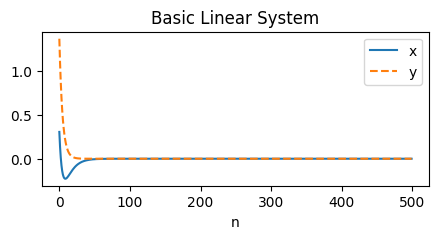

In [3]:
# Define the true forward linear operator.
J = np.array([[0.9, -0.1], [0.0, 0.8]])

# Simulate testing data using 500 random initial conditions.
m = 500
rng = np.random.default_rng(seed=42)  # seed for reproducibility
X = rng.standard_normal((2, m))
Y = J.dot(X)

# Use model to propagate a single initial condition forward.
X2 = np.empty(X.shape)
X2[:, 0] = X[:, 0]
for j in range(m - 1):
    X2[:, j + 1] = J.dot(X2[:, j])

# Plot example trajectory.
plt.figure(figsize=(5, 2))
plt.title("Basic Linear System")
plt.plot(X2[0], label="x")
plt.plot(X2[1], "--", label="y")
plt.xlabel("n")
plt.legend()
plt.show()

As derived and discussed in [1], the true Koopman eigenfunctions and eigenvalues of this particular system are respectively given by

$$
\varphi_{ij}(x,y) = \left( \frac{x-y}{\sqrt{2}} \right)^i y^j, \qquad
\lambda_{ij} = (0.9)^i(0.8)^j
$$

for $i, j \in \mathbb{Z}$. Here, we examine the grid $x, y \in [-5, 5]$ and begin by evaluating the first 10 eigenfunctions along this grid.

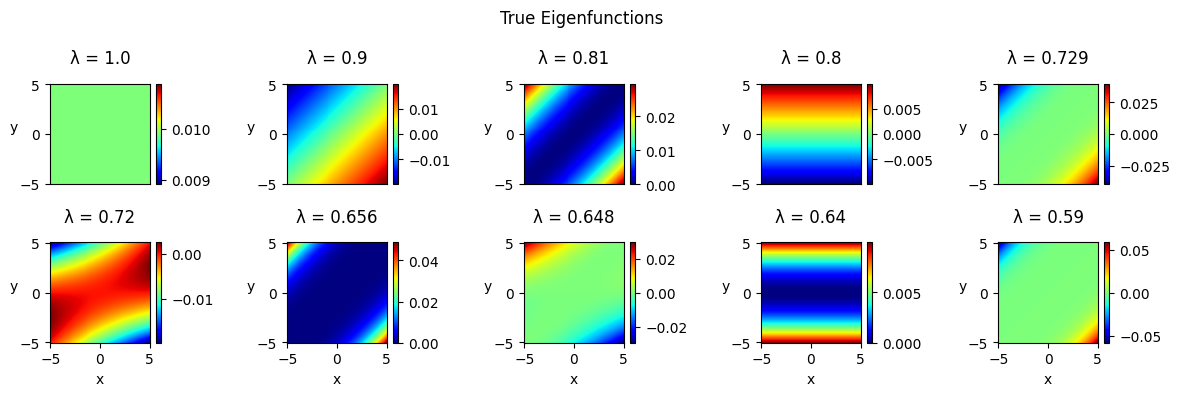

In [4]:
# Define the x, y grid.
x_vals = np.linspace(-5, 5, 101)
y_vals = np.linspace(5, -5, 101)
X_grid, Y_grid = np.meshgrid(x_vals, y_vals)

# Define the (i, j) index pairs for the first 10 eigenfunctions.
i_indices = [0, 1, 2, 0, 3, 1, 4, 2, 0, 5]
j_indices = [0, 0, 0, 1, 0, 1, 0, 1, 2, 0]

# Compute the ground truth eigenvalues and eigenfunctions along the xy-grid.
eigenfunctions_true = np.empty((len(i_indices), *X_grid.shape))
eigenvalues_true = np.empty(len(i_indices))

for idx, (i, j) in enumerate(zip(i_indices, j_indices)):
    eigenfunc = np.multiply(((X_grid - Y_grid) / np.sqrt(2)) ** i, Y_grid**j)
    eigenfunc /= np.linalg.norm(
        eigenfunc, np.inf
    )  # scale to have infinity norm 1
    eigenfunctions_true[idx] = eigenfunc
    eigenvalues_true[idx] = (0.9**i) * (0.8**j)

# Plot the ground truth eigenvalues and eigenfunctions.
plot_eigenfunctions(
    eigenvalues_true,
    eigenfunctions_true,
    suptitle="True Eigenfunctions",
)

## DMD cannot capture everything...

Although our toy system is linear and hence can be modeled with exact DMD, notice that since our snapshots are only 2-dimensional, we can only ever obtain a rank-2 system and hence only 2 eigenvalue, eigenfunction pairs. We demonstrate this phenomenon below and note that although exact DMD is able to accurately recover 2 eigenvalues, the method cannot obtain any more eigenvalues and hence cannot obtain the rich set of eigenvalue, eigenfunction pairs that are associated with this system [1].

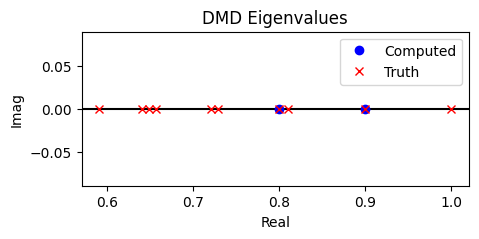

In [5]:
# Even if we build a DMD model with a higher svd_rank, we cannot
# compute more than 2 eigenvalues due to the shape of the data...
dmd = DMD(svd_rank=10).fit(X, Y)
plot_eigs(dmd.eigs, title="DMD Eigenvalues")

## Applying EDMD with kernels: the polynomial kernel

It was shown in the original EDMD paper that one may use EDMD with a feature library of Hermite polynomials in order to recover the leading-order eigenfunctions and eigenvalues of this particular system [1]. Here, we demonstrate that one may obtain similar results by using the kernelized version of the algorithm [2] in conjunction with appropriately-chosen kernel functions.

First, we note that the `EDMD` module uses [`sklearn.metrics.pairwise.pairwise_kernels`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_kernels.html) behind the scenes for kernel matrix computations. Hence, two major parameters control which kernel function is used by the module:
- `kernel_metric` - a string which defines the class of kernel function to use. Valid class names include:

    `"additive_chi2"`, `"chi2"`, `"linear"`, `"poly"`, `"polynomial"`, `"rbf"`, `"laplacian"`, `"sigmoid"`, `"cosine"`.


- `kernel_params` - a dictionary that contains additional parameters to the `pairwise_kernels` function (please refer to the documentation linked above). Kernel function parameters may be defined via this dictionary.

To demonstrate how one might define their kernel function when using the `EDMD` module, we define an `EDMD` model that uses the polynomial kernel

$$
k_{\text{poly}}(\mathbf{x}, \mathbf{y}) = (\gamma \mathbf{x}^\top \mathbf{y} + c_0)^d
$$

by setting `kernel_metric="poly"`. We then define the values of the additional parameters $\gamma, c_0, d$ via entries of the `kernel_params` dictionary, which we note are defined via the parameters `"gamma"`, `"coef0"`, and `"degree"` respectively. In the example below, we use $\gamma=1$, $c_0=1$, and $d=4$. Please refer to the [scikit-learn user guide](https://scikit-learn.org/stable/modules/metrics.html#metrics) for more details on the available kernel metrics and their associated parameters.

In [6]:
# Define the kernel parameter dictionary.
kernel_params = {}
kernel_params["gamma"] = 1
kernel_params["coef0"] = 1
kernel_params["degree"] = 4

# Define and fit an EDMD model with the polynomial kernel.
edmd = EDMD(kernel_metric="poly", kernel_params=kernel_params).fit(X, Y)

## Eliminating spurious eigenvalues

Note that unlike other PyDMD modules, the `EDMD` module is *not* compatible with the `svd_rank=0` option, which is commonly used for automatically computing and using the optimal rank of the data. Instead, the kernelized EDMD method uses the eigendecomposition of the Gramian matrix

$$
\hat{\mathbf{G}}_{ij} = k(\mathbf{x}_i, \mathbf{x}_j)
$$

in order to construct the eigendecomposition of the EDMD operator, and hence solely uses the eigenvalues of the Gramian in order to determine an appropriate rank truncation. By default, the `EDMD` module does not perform a rank truncation. However, it should be noted that the singular values of the Gramian, which are accessible via the `EDMDOperator` property `svd_vals`, tend to decay quite rapidly, with a appropriate rank truncation often aiding the method's accuracy and ability to rule out spurious eigenvalues [2].

We demonstrate this below by plotting the singular value spectrum obtained when we fit an `EDMD` model to our toy system using the polynomial kernel defined above along with no rank truncation. Note the abundance of singular values that are approximately zero. Additionally note the abundance of spurious eigenvalues that result from a lack of truncation. Then following the number of significantly-large singular values, we fit a new `EDMD` model using the same kernel function as before, but with a rank truncation of `svd_rank=15`. Note the considerable clarity in the computed eigenvalues that results from this truncation. Also note that rank truncations via energy (i.e. using `svd_rank=0.95` to retain $95\%$ of energy) are also compatible with the `EDMD` class.

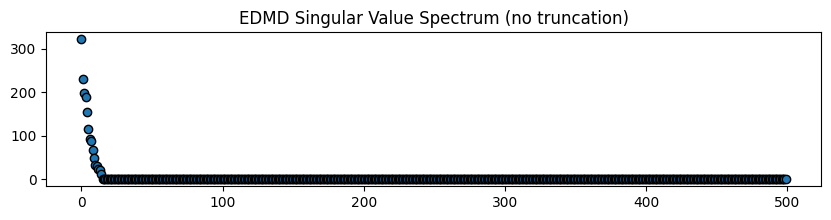

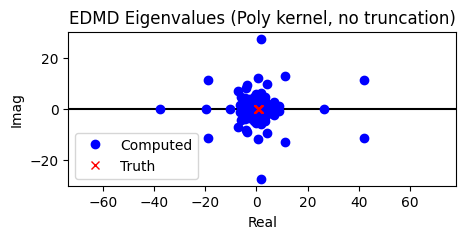

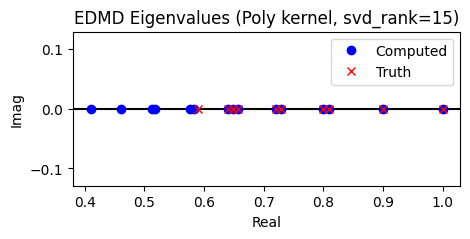

In [7]:
# Plot the singular value spectrum.
plt.figure(figsize=(10, 2))
plt.title("EDMD Singular Value Spectrum (no truncation)")
plt.plot(edmd.operator.svd_vals, "o", mec="k")
plt.show()

# Plot the computed eigenvalues against the truth.
plot_eigs(edmd.eigs, title="EDMD Eigenvalues (Poly kernel, no truncation)")

# Fit a new EDMD model with the polynomial kernel and a set rank truncation.
edmd = EDMD(svd_rank=15, kernel_metric="poly", kernel_params=kernel_params).fit(
    X, Y
)

# Plot the computed eigenvalues against the truth.
plot_eigs(edmd.eigs, title="EDMD Eigenvalues (Poly kernel, svd_rank=15)")

## Evaluating eigenfunctions

Once we have fitted our `EDMD` model, we may then evaluate our eigenfunctions via the function `edmd.eigenfunctions(x)`, where the input `x` is a member of the original state space $\mathcal{M}$. The function then returns the vector

$$
\begin{bmatrix}
\varphi_1(\mathbf{x}) \\ \vdots \\ \varphi_r(\mathbf{x})
\end{bmatrix} \in \mathbb{C}^r,
$$

where $\varphi_i(\mathbf{x})$ denotes the $i$th eigenfunction evaluated at $\mathbf{x} \in \mathcal{M}$ and $r$ denotes the rank of the fit. Hence for our particular toy system, we can attempt to re-obtain the true eigenfunctions by evaluating `edmd.eigenfunctions` at every desired grid point $(x, y) \in \mathbb{R}^2$ using our fitted model `edmd`. Notice from our visualizations below that EDMD is able to recover the leading 9 eigenfunctions and eigenvalues, with the majority of eigenfunctions deviating from the truth by a factor of $-1$ at worst.

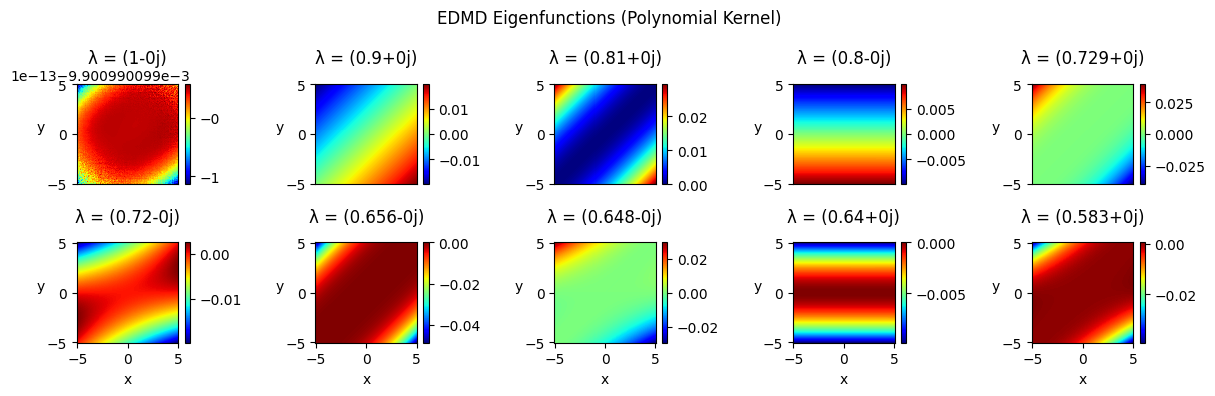

In [8]:
# Evaluate eigenfunctions from EDMD along the grid.
eigenfunctions = np.empty((15, *X_grid.shape))
for y_idx, y in enumerate(y_vals):
    for x_idx, x in enumerate(x_vals):
        xy_vec = np.array([x, y])
        eigenfunctions[:, y_idx, x_idx] = edmd.eigenfunctions(xy_vec).real

# Scale eigenfunctions to have infinity norm 1.
for eigenfunction in eigenfunctions:
    eigenfunction /= np.linalg.norm(eigenfunction, np.inf)

# Sort the eigenvalues and eigenfunctions according to eigenvalue modulus.
edmd_eigs, edmd_funcs, sorted_inds = sort_eigs(edmd.eigs, eigenfunctions)

# Plot the 10 leading EDMD eigenvalues and eigenfunctions.
plot_eigenfunctions(
    edmd_eigs[:10],
    edmd_funcs[:10],
    suptitle="EDMD Eigenfunctions (Polynomial Kernel)",
)

## Obtaining modes and reconstructions

As a final note, notice that upon viewing the computed EDMD modes, one will find that the majority of them are zero for this particular system.

Basically to quote the original EDMD paper:

"*Although EDMD reveals a richer set of Koopman eigenfunctions that are analytically known to exist, their associated Koopman modes are zero, and hence, they can be neglected. Our goal in presenting this example is not to demonstrate any new phenomenon, but rather to demonstrate that there is good quantitative agreement between the analytically obtained Koopman modes, eigenvalues, and eigenfunctions and the approximations produced by EDMD.*" [1]

In [9]:
# Sort, round, and print the EDMD modes.
edmd_modes = np.round(edmd.modes[:, sorted_inds], decimals=3)
print(edmd_modes.T)

[[ 0.   -0.j -0.   +0.j]
 [ 0.707-0.j -0.   -0.j]
 [-0.   +0.j -0.   +0.j]
 [-0.5  -0.j -0.5  -0.j]
 [ 0.   -0.j  0.   -0.j]
 [ 0.   -0.j  0.   -0.j]
 [ 0.   +0.j  0.   -0.j]
 [-0.   +0.j -0.   +0.j]
 [ 0.   +0.j  0.   +0.j]
 [-0.   +0.j -0.   -0.j]
 [ 0.   +0.j  0.   -0.j]
 [-0.   +0.j -0.   +0.j]
 [-0.   -0.j -0.   +0.j]
 [ 0.   -0.j  0.   -0.j]
 [ 0.   +0.j -0.   +0.j]]


Hence on top of being able to obtain a rich set of eigenvalues and eigenfunctions that are otherwise unobtainable due to a lack of sufficient dimensionality in the original snapshots, EDMD is able to not only accurately re-obtain the true linear operator $\mathbf{J}$...

In [10]:
# Note: this computation is feasible due to the small dimension of the toy system, however
# we caution users against such a computation in the event that the dimension of one's data
# snapshots is prohibitively large...
J_est = np.linalg.multi_dot(
    [edmd.modes, np.diag(edmd.eigs), np.linalg.pinv(edmd.modes)]
)
print(np.round(J_est, decimals=3))

[[ 0.9-0.j -0.1+0.j]
 [-0. -0.j  0.8+0.j]]


...but it is also able to obtain accurate future-state predictions, at least for the toy system at hand.

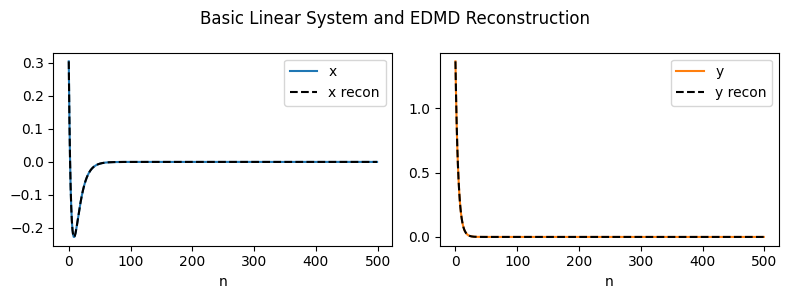

In [11]:
# Re-plot the example trajectory.
plt.figure(figsize=(8, 3))
plt.suptitle("Basic Linear System and EDMD Reconstruction")
plt.subplot(1, 2, 1)
plt.plot(X2[0], label="x")
plt.plot(edmd.reconstructed_data[0].real, "k--", label="x recon")
plt.xlabel("n")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(X2[1], label="y", c="tab:orange")
plt.plot(edmd.reconstructed_data[1].real, "k--", label="y recon")
plt.xlabel("n")
plt.legend()
plt.tight_layout()
plt.show()

## Applying EDMD with kernels: the RBF kernel

As a final example, we define and fit an `EDMD` model that uses the RBF kernel

$$
k_{\text{RBF}}(\mathbf{x}, \mathbf{y}) = \text{exp} \left(-\gamma \| \mathbf{x}-\mathbf{y}\|_2^2\right)
$$

for $\gamma = 10^{-3}$. We again direct users to the [scikit-learn user guide](https://scikit-learn.org/stable/modules/metrics.html#metrics) for more information on the compatible kernel functions and their respective paramters. Following our previous discussion on rank truncations, we again use a rank trunction of $15$. Notice that when using the RBF kernel, one is still able to accurately obtain most of the leading eigenvalues and eigenfunctions. We take this as an opportunity to encourage users to explore a variety of kernel functions and parameterizations when using the `EDMD` module!

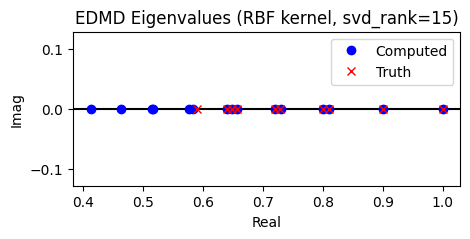

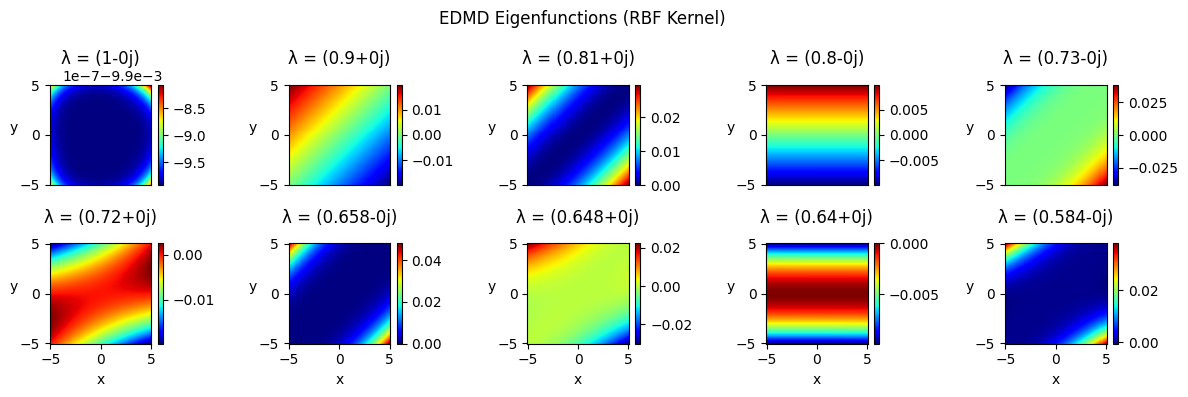

In [12]:
# Fit a new EDMD model with the rbf kernel and rank truncation 15.
edmd = EDMD(
    svd_rank=15,
    kernel_metric="rbf",
    kernel_params={"gamma": 0.001},
).fit(X, Y)

# Plot the computed eigenvalues against the truth.
plot_eigs(edmd.eigs, title="EDMD Eigenvalues (RBF kernel, svd_rank=15)")

# Evaluate eigenfunctions from EDMD along the grid.
eigenfunctions = np.empty((15, *X_grid.shape))
for y_idx, y in enumerate(y_vals):
    for x_idx, x in enumerate(x_vals):
        xy_vec = np.array([x, y])
        eigenfunctions[:, y_idx, x_idx] = edmd.eigenfunctions(xy_vec).real

# Scale eigenfunctions to have infinity norm 1.
for eigenfunction in eigenfunctions:
    eigenfunction /= np.linalg.norm(eigenfunction, np.inf)

# Sort the eigenvalues and eigenfunctions according to eigenvalue modulus.
edmd_eigs, edmd_funcs, sorted_inds = sort_eigs(edmd.eigs, eigenfunctions)

# Plot the 10 leading EDMD eigenvalues and eigenfunctions.
plot_eigenfunctions(
    edmd_eigs[:10],
    edmd_funcs[:10],
    suptitle="EDMD Eigenfunctions (RBF Kernel)",
)

## In Summary...
- Consider using the `EDMD` module when either...

    (1) you hope to obtain a rich set of eigenvalues and nonlinear eigenfunctions that are otherwise unobtainable due to a lack of sufficient dimensionality, or
    (2) your data possesses nonlinearities that cannot be modeled solely and directly by a simple linear operator.
    
    
- Rank truncations need to be applied to `EDMD` models manually, either via an integer rank cutoff `svd_rank=r`, or via a specified amount of energy `svd_rank=energy`. Remember to do so, as rank truncations help eliminate spurious eigenvalues! Use the EDMD operator attribute `svd_vals` to help visualize the singular value spectrum and help guide your truncations.


- The `EDMD` module uses [`sklearn.metrics.pairwise.pairwise_kernels`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_kernels.html) behind the scenes for all kernel matrix computations. The `kernel_metric` string controls the kernel metric, whereas the `kernel_params` dictionary manages all other arguments to the `pairwise_kernels` function. Various kernels may yield different results, so we encourage users to experiment with a variety of kernel functions!


- A fitted `EDMD` model is capable of outputting eigenfunctions via a call to `edmd.eigenfunctions(x)` for a vector `x` in the original domain of the data. Eigenvalues, modes, and data reconstructions are also available for use once the model is fitted.


- If one's data possesses strong nonlinearities and still cannot be modeled accurately and efficiently by EDMD, we direct readers to these other methods: [LANDO](https://doi.org/10.1098/rspa.2021.0830), [HAVOK](https://doi.org/10.1038/s41467-017-00030-8), [SINDy](https://doi.org/10.1073/pnas.1517384113)